# Implémentation des modèles de simulation du papier

Ce notebook est fait pour reproduire des résultats similaire au papier [Estimating behavioral parameters in animal movement models using a state-augmented particle filter](https://dalspace.library.dal.ca/bitstream/handle/10222/33464/Dowd_et_al-2011-Ecology.pdf), en utilisant la librairie `particles` et les fonctions définies dans le module `smc_movement_models.models`.

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [371]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import smc_movement_models.models as smc_model
import smc_movement_models.plots as smc_plot

np.random.seed(42)

## Chargement des données

In [10]:
df = pd.read_csv("../data/clean_data.csv")

In [11]:
# day_str = "26/01/2008"
day_str_min = "18/01/2008"
day_str_max = "18/01/2008"
mask_day = (df["Date"] >= day_str_min) & (df["Date"] <= day_str_max)
day = df.loc[mask_day, ["Dtime", "Velocity", "Depth"]]
day["Dtime"] = pd.to_datetime(day["Dtime"])

[Text(0.5, 0, 'Time of day'), Text(0, 0.5, 'Depth (m)')]

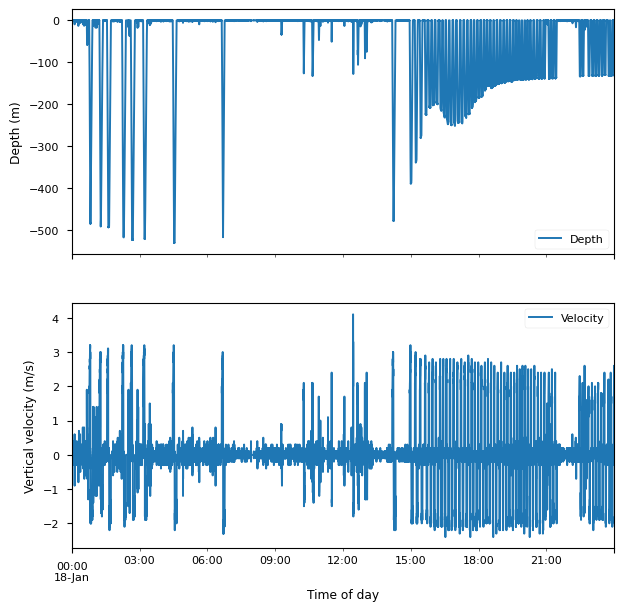

In [424]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 7))

day.plot(x="Dtime", y="Velocity", ax=ax2)
day.plot(x="Dtime", y="Depth", ax=ax1)
ax2.set(xlabel="Time of day", ylabel="Vertical velocity (m/s)")
ax1.set(xlabel="Time of day", ylabel="Depth (m)")

In [281]:
# Génération des fenêtres
windows, window_times = smc_model.get_windows(day)

## Estimation des variances

Dans un premier temps, nous allons estimer les variances des erreurs de mesure et d'observation. Pour ce faire, nous utilisons la méthodologie décrite dans le papier en Annexe A.

In [284]:
sigma_ods, sigma_eds, sigma_zds, mses, acvfs = smc_model.estimate_variance_on_all_windows(windows)

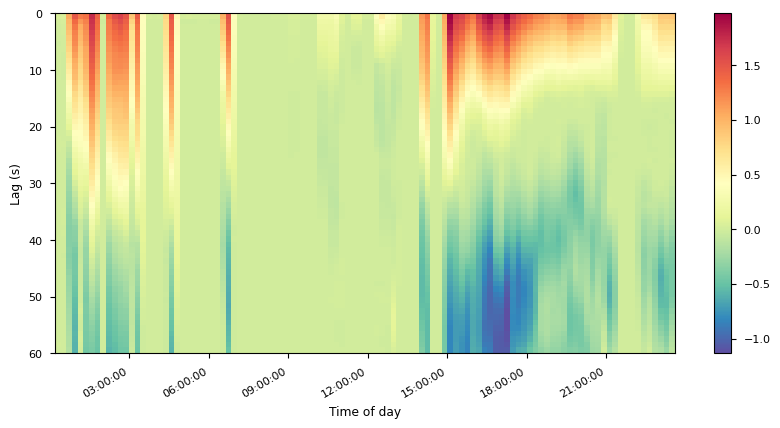

In [291]:
acvf_fig = smc_plot.plot_acvf(acvfs, window_times)

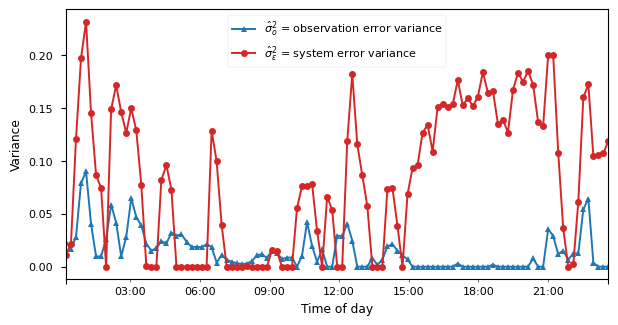

In [292]:
var_fig = smc_plot.plot_variance_estimates(sigma_eds, sigma_ods, window_times)

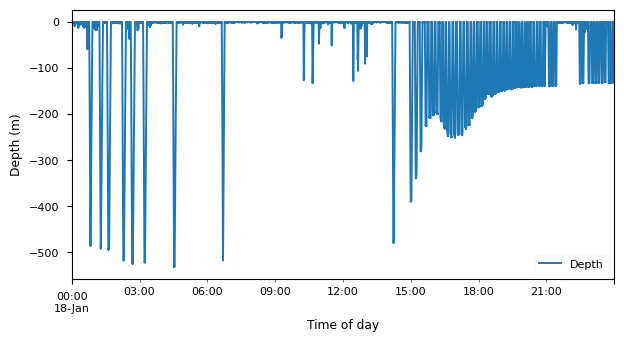

In [294]:
depth_fig = smc_plot.plot_depth(day)

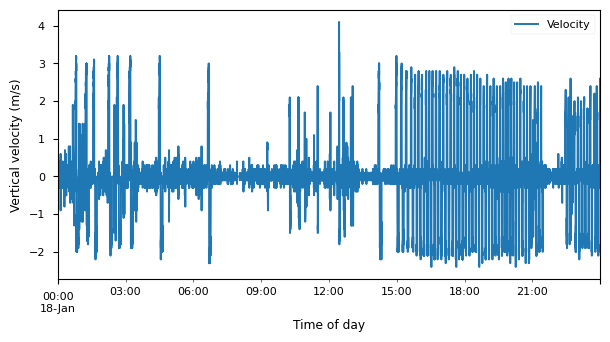

In [295]:
velocity_fig = smc_plot.plot_velocity(day)


## Estimation des paramètres latents

Dans cette section, nous allons estimer les paramètres latents du modèle. Pour ce faire, nous utilisons la méthodologie décrite dans le papier.

In [ ]:
# sigma_os = np.ones_like(sigma_ods) * 0.5
# sigma_es = np.ones_like(sigma_eds) * 0.5
sigma_os = np.sqrt(sigma_ods)
sigma_es = np.sqrt(sigma_eds)

In [ ]:
# Algorithme sur toutes les fenêtres (une fois)
time_results = smc_model.estimate_a1_a2_on_all_windows(
    windows=windows,
    window_times=window_times,
    sigma_os=sigma_os,
    sigma_es=sigma_es,
    N=500,
    M=10,
    initial_a1=0,
    initial_a2=0,
    initial_sigma_v=0.1,
    alpha=0.5,
    c1=0.9,
    c2=0.1,
    delta=10,
)

100%|██████████| 109/109 [01:39<00:00,  1.10it/s]


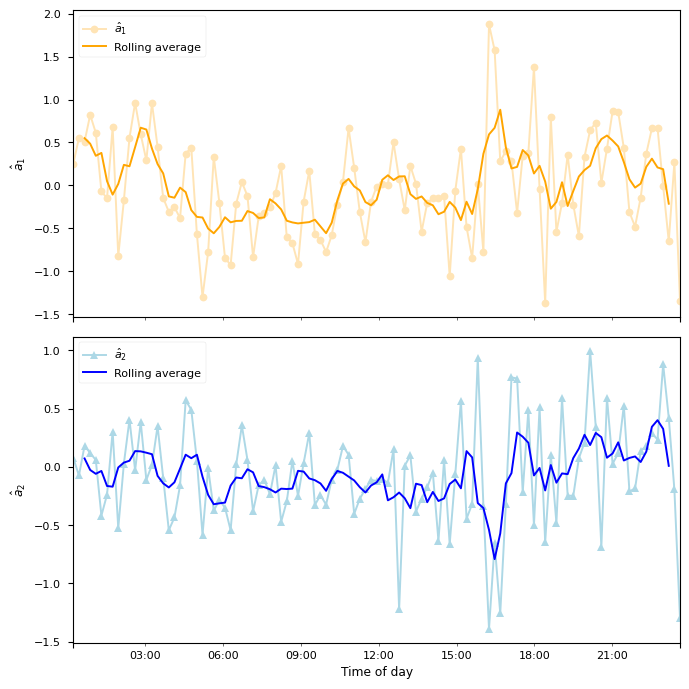

In [360]:
a1_a2_fig = smc_plot.plot_a1_a2(time_results, figsize=(7, 7))

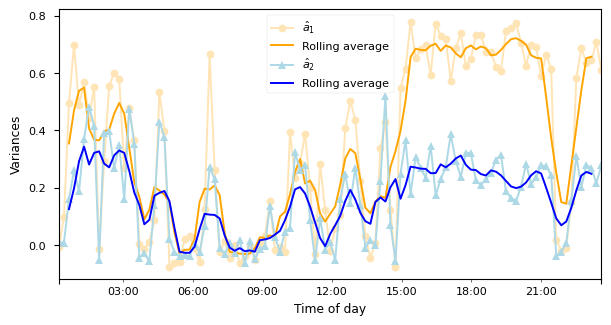

In [388]:
a1_a2_fig_single_plot = smc_plot.plot_a1_a2_single_plot(time_results, figsize=(7, 3.5))

In [389]:
# On répète l'algorithme 10 fois pour avoir une idée de la variance des paramètres
results_var = []

for i in tqdm(range(10)):
    time_results = smc_model.estimate_a1_a2_on_all_windows(
        windows=windows,
        window_times=window_times,
        sigma_os=sigma_os,
        sigma_es=sigma_es,
        N=500,
        M=10,
        initial_a1=0,
        initial_a2=0,
        initial_sigma_v=0.1,
        alpha=0.5,
        c1=0.9,
        c2=0.1,
        delta=10,
    )
    results_var.append(time_results)

final_res = pd.DataFrame()
for i, res in enumerate(results_var):
    res["run"] = i
    final_res = pd.concat([final_res, res])

100%|██████████| 10/10 [16:36<00:00, 99.66s/it]


In [ ]:
# Meme chose mais dans une fonction et 20 fois (prend 30min)
final_res = smc_model.rerun_algo(
    windows=windows,
    window_times=window_times,
    sigma_os=sigma_os,
    sigma_es=sigma_es,
    nb_runs=20,
    N=500,
    M=10,
    initial_a1=0,
    initial_a2=0,
    initial_sigma_v=0.1,
    alpha=0.5,
    c1=0.9,
    c2=0.1,
    delta=10,
)

C:\Users\gabri\AppData\Local\Temp\ipykernel_1532\1860597235.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=final_res["Dtime"].iloc[x_ids].dt.strftime('%H:%M'), rotation=45, ha='right')


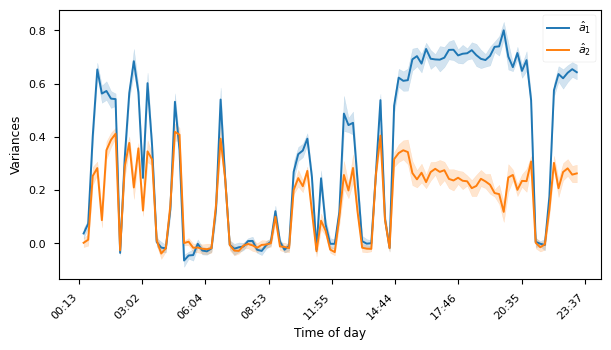

In [422]:
a1_a2_var = smc_plot.plot_a1_a2_var(final_res)